In [1]:
import pandas as pd
df = pd.read_csv('Data/cv-valid-train.csv')
df.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [85]:
from pydub import AudioSegment

audio = AudioSegment.from_mp3('Data/cv-valid-train/sample-101572.mp3')
len(audio)

11832

In [3]:
def syllables(phrase):
    sep_words = phrase.split(' ')
    syllables_lst = []
    vowels = 'aieouy'
    doubles = ['ia','eo','ier','iest','eing','io']
    for word in sep_words:
        count = 0
        is_consonant = True
        for letter in word:
            if letter in vowels and is_consonant:
                count +=1
                is_consonant = False
            elif letter not in vowels:
                is_consonant = True
        if len(word)>1 and count>1:
            if word[-1]=='e' and word[-2] not in vowels:
                count -=1
        for pair in doubles: 
            if pair in word: count +=1
        if ('nion' in word) or ('tion' in word) or ('sion' in word):
            count -=1
        syllables_lst.append(count)
    
    return syllables_lst

In [87]:
audio

In [86]:
a_text = df['text'][101572]
print(a_text)
syllables(a_text)

you must always know what it is that you want the old king had said


[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Text(0.5, 1.0, 'Full Audio Sample\nlearn to recognize omens and follow them the old king had said')

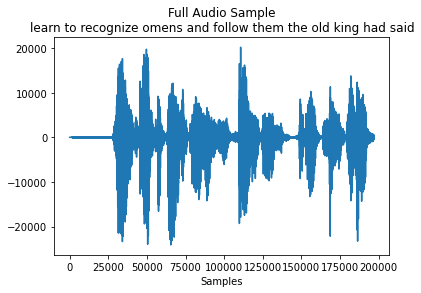

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

full = np.array(audio.get_array_of_samples())
plt.plot(range(len(full)),full)
plt.xlabel('Samples')
plt.title(f'Full Audio Sample\n{a_text}')

In [94]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

normalized_sound = match_target_amplitude(audio, -20.0)

from pydub import silence
nonsils = silence.detect_nonsilent(normalized_sound,min_silence_len=100,silence_thresh=-45)


normalized_sound

In [95]:
nonsilent_lst = []
for pair in nonsils:
    nonsilent_lst.append(audio[pair[0]:pair[1]])
nonsilent=sum(nonsilent_lst)

total_time = len(nonsilent)
aud_list = []
current_time = 0
total_sybs = sum(syllables(a_text))
for word in syllables(a_text):
    time = total_time*word/total_sybs
    aud_list.append(nonsilent[current_time:current_time+time])
    current_time +=time
    
nonsilent

In [96]:
words = []
for word in a_text.split(' '):
    words.append(word)

101552

she: she
has: hasa (too much)
always: lwaysbe (too much)
been: er (?) 
very: kind (ahead)
kind: urf (?)
and: an
friendly: ly to ev (ahead)
to: ery (ahead)
everyone: n even (ahead)
even: stran (ahead)
strangers: gers (not enough)

In [101]:
x = 2
selection = aud_list[x] 
print(words[x])
selection

always


In [ ]:
selection = aud_list[11] 
selection

Text(0.5, 1.0, 'Nonsilent Audio')

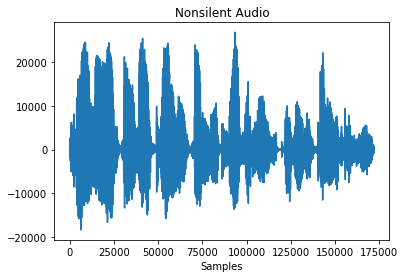

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
nonsilent_samps = np.array(nonsilent.get_array_of_samples())
plt.plot(range(len(nonsilent_samps)),nonsilent_samps)
plt.xlabel('Samples')
plt.title('Nonsilent Audio')

In [11]:
for aud,word in zip(aud_list,a_text.split(' ')):
    plt.figure()
    aud_samps = np.array(aud.get_array_of_samples())
    plt.plot(range(len(aud_samps)),aud_samps)
    plt.xlabel('Samples')
    plt.title(word)
    plt.show()

NameError: name 'plt' is not defined

In [9]:
2000/48

41.666666666666664

In [15]:
import numpy as np
default_rate= 48000

selection = aud_list[3] 

temp = selection.set_frame_rate(round(default_rate*62.5/len(selection)))
print(temp.frame_rate)
print(len(temp))
samps = np.array(temp.get_array_of_samples())
#if samps.shape[0]<12000:samps = np.append(samps,[0]*(12000-samps.shape[0]))
#samps = samps[:12000]
print(samps.shape)
temp

8955
335
(3000,)


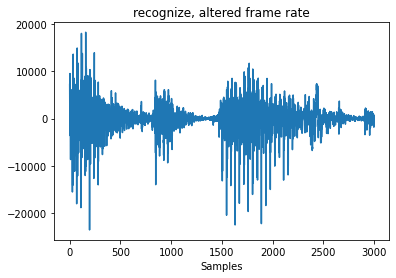

In [17]:
plt.figure()
temp_samps = np.array(temp.get_array_of_samples())
plt.plot(range(len(temp_samps)),temp_samps)
plt.xlabel('Samples')
plt.title('recognize, altered frame rate')
plt.show()

In [ ]:
for aud in aud_list:
    samps = np.array(aud.get_array_of_samples())
    print(len(aud),samps.shape)

In [14]:
temp

In [144]:
temp.sample_width

2

In [156]:
temp.frame_rate

18987

In [162]:
audio_segment = AudioSegment(samps,frame_rate=2*temp.frame_rate,
                             sample_width=2,channels=1)
audio_segment

### Next steps:
* so, I know *how* I'm processing the data
* process all the data? Maybe pick a subset, cause *yikes*
* upload audio, get syllable counts, delete silence, split audio
* from there... make new database of word and audio, and np array
* add zeroes to max number?? What if future values are longer??

In [152]:
txt_ = 'Data/'+df['filename'][35]
wrong_syls = AudioSegment.from_mp3(txt_)
print(len(wrong_syls))

a_text = df['text'][35]
print(a_text)
print(syllables(a_text))
nonsils = silence.detect_nonsilent(wrong_syls,min_silence_len=100,silence_thresh=-50)

nonsilent_lst = []
for pair in nonsils:
    nonsilent_lst.append(wrong_syls[pair[0]:pair[1]])
nonsilent=sum(nonsilent_lst)

total_time = len(nonsilent)
print(total_time)
aud_list_comp = []
current_time = 0
total_sybs = sum(syllables(a_text))
counts = syllables(a_text)
counts[7] = 4
#print(counts)
for word in counts:
    time = total_time*word/total_sybs
    aud_list_comp.append(nonsilent[current_time:current_time+time])
    current_time +=time

5304
the boy was strong and wanted to retaliate but he was in a foreign country
[1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 2]
4084


In [157]:
aud_list[-2]

In [156]:
aud_list_comp[-2]

Note: probably not worth extra effort of perfectly identifying syllables, as it's not 100% accurate to timing anyways. Sample 35 contains "retaliate" which my system misclassifies as 3 syllables, but the compensated version is not significantly more accurate than incorrect version

In [94]:
vocab = set()
for phrase in df['text'].unique():
    words = phrase.split(' ')
    for word in words:
        vocab.add(word)
len(vocab)

8004

In [99]:
bag_of_words = {}
for phrase in df['text']:
    for word in phrase.split(' '):
        bag_of_words[word] = bag_of_words.get(word,0)+1
sort_bow = {k:v for k,v in sorted(bag_of_words.items(),key=lambda item:item[1],reverse=True)}
sort_bow

{'the': 141274,
 'to': 55997,
 'and': 41557,
 'a': 40516,
 'of': 36293,
 'he': 35046,
 'i': 33705,
 'was': 29991,
 'it': 27355,
 'you': 26954,
 'that': 26453,
 'in': 22927,
 'boy': 17282,
 'had': 16445,
 'his': 13948,
 'said': 12606,
 'with': 11899,
 'is': 11796,
 'for': 11648,
 'but': 11001,
 'they': 10652,
 'at': 10361,
 'my': 10125,
 'have': 9766,
 'be': 9530,
 'me': 9109,
 'about': 8984,
 'on': 8928,
 'what': 8699,
 'were': 8655,
 'there': 8458,
 'him': 7981,
 'this': 7674,
 'one': 7670,
 'as': 7551,
 'from': 7460,
 'do': 6475,
 'all': 6241,
 'not': 6232,
 'out': 6174,
 "don't": 6129,
 'are': 6063,
 "i'm": 5813,
 'so': 5685,
 'your': 5684,
 'thought': 5496,
 'know': 5468,
 'alchemist': 5359,
 'people': 5258,
 'man': 5074,
 'then': 4932,
 'no': 4820,
 'them': 4731,
 'when': 4689,
 'we': 4612,
 'she': 4565,
 'been': 4561,
 'if': 4519,
 'an': 4437,
 'up': 4399,
 'can': 4335,
 'just': 4274,
 'how': 4267,
 'time': 4258,
 "it's": 4200,
 'get': 4171,
 'old': 4127,
 'their': 4039,
 'would'

In [141]:
#bow_df = pd.DataFrame([bag_of_words.keys(),bag_of_words.values()]).T
#bow_df.columns = ['word','count']
bow_df.loc[bow_df['count']>10].count()

word     5364
count    5364
dtype: int64

In [163]:
all_words = ' '.join(vocab)
all_syls = syllables(all_words)
syls_df = pd.DataFrame([vocab,all_syls]).T
syls_df.columns = ['word','syllables']
syls_df[5:50]

,word,syllables
5,intrigue,3
6,instead,2
7,kyle's,2
8,hostages,3
9,pipeline,3
10,worms,1
11,declared,3
12,phone,1
13,goal,1
14,nothing's,2
